# **Detecting Spam Emails Using Tensorflow in Python**

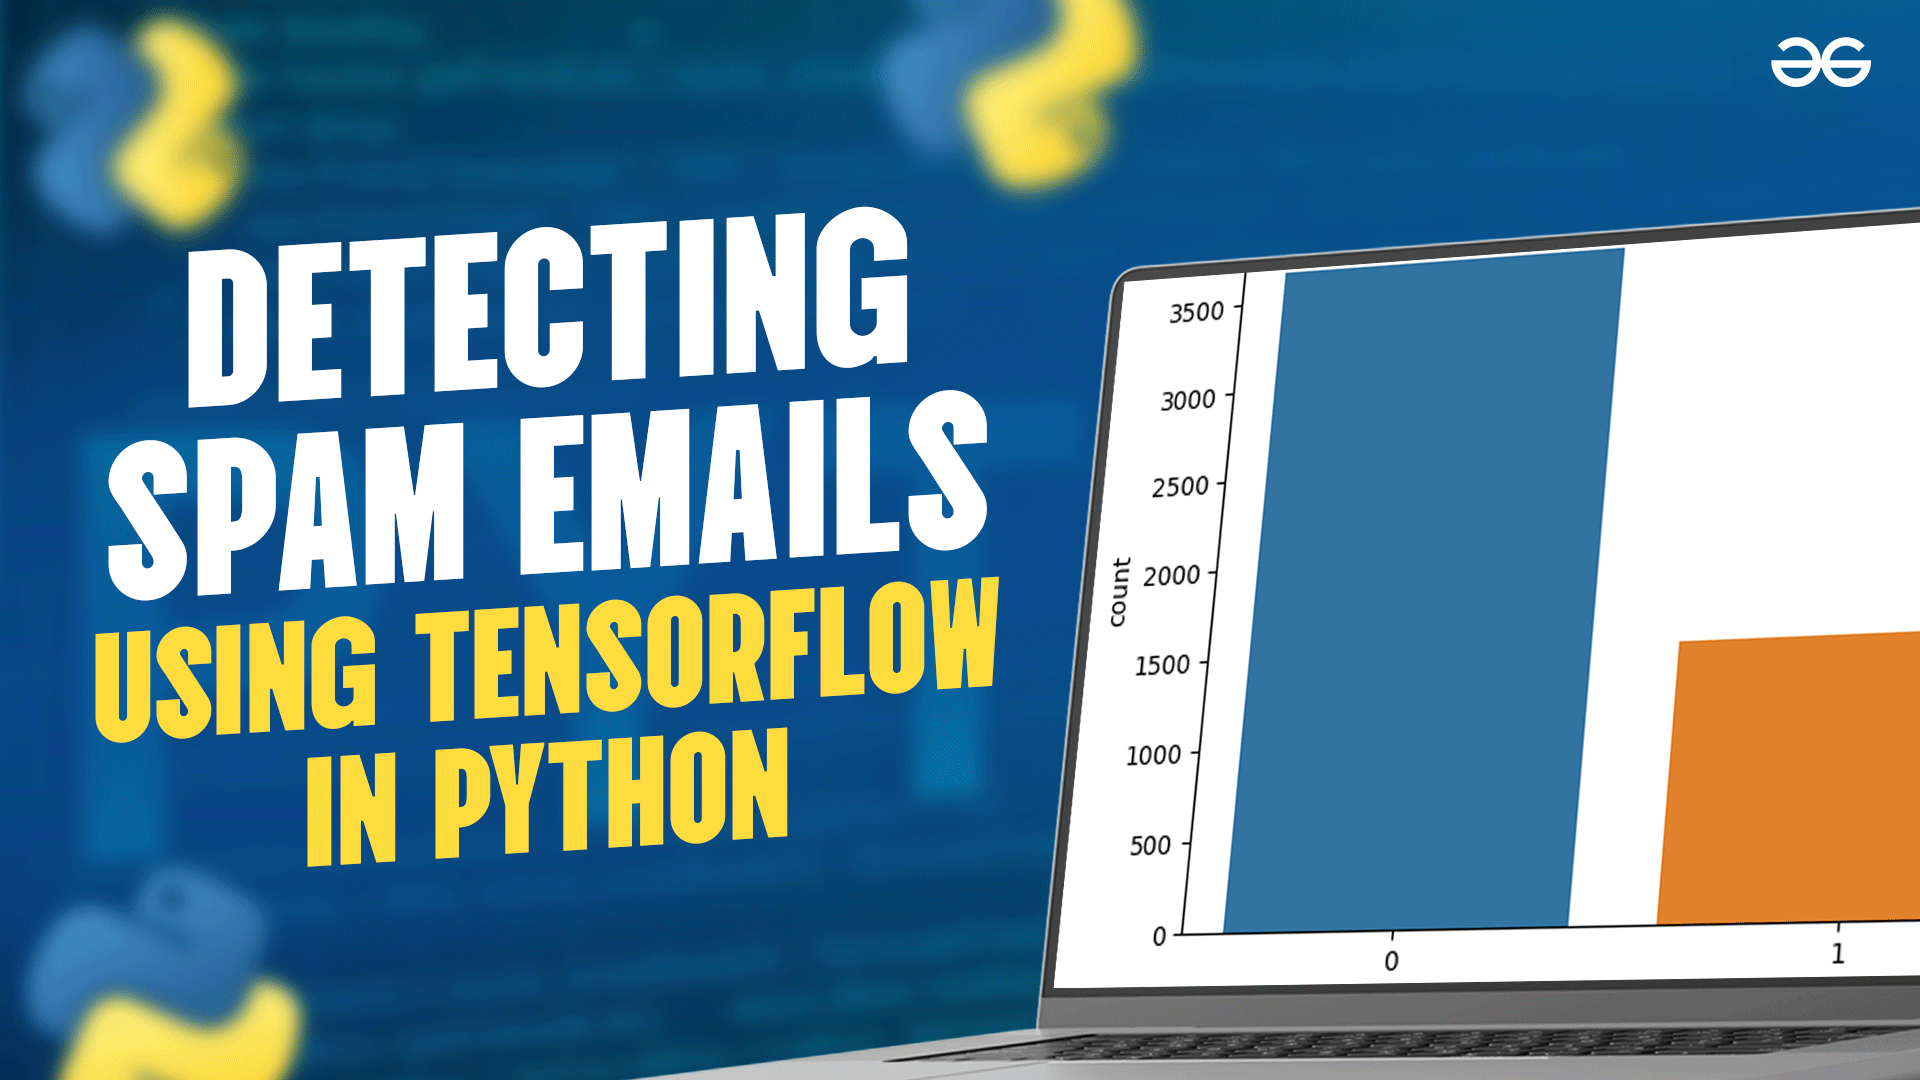

This project aims to create a system that can automatically identify and filter out unwanted emails (spam) from your inbox. 


I'll use TensorFlow, a powerful tool for machine learning, to build a model that can distinguish between spam and legitimate emails (ham)."

## **Step 1: Import Required Libraries**

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Adeleke\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **Step 1: Load the Dataset**

In [25]:
data = pd.read_csv('spam_ham_dataset.csv')
data.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [26]:
data.shape

(5171, 4)

The data contains 5171 rows and four columns.

Now, let's visualize the label distribution to get understanding of the class distribution:

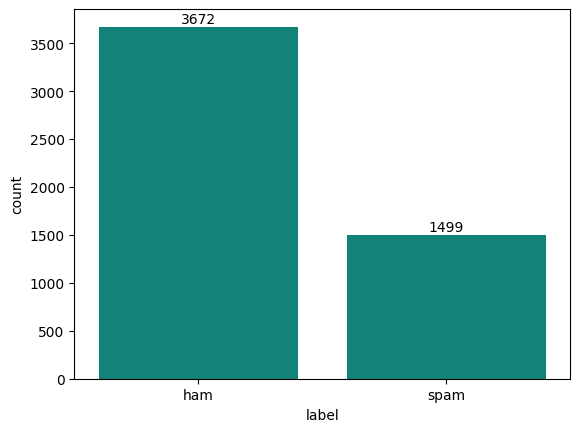

In [27]:
sns.countplot(x=data['label'], color = '#009688')

# Add data labels
for p in plt.gca().patches:
    plt.text(
        p.get_x() + p.get_width() / 2, 
        p.get_height() + 5, 
        int(p.get_height()), 
        ha='center', 
        va='bottom'
    )

plt.show()

## **Step 3: Balance the Dataset**

We can clearly see that number of samples of Ham is much more than that of Spam which implies that the dataset we are using is imbalanced. To address the imbalance I’ll 

- Separates the data into spam and ham.
- Upsamples the spam messages by randomly duplicating them until they match the number of ham messages.
- Combines the upsampled spam and original ham, shuffles them, and resets the index to create a balanced dataset (data_balanced).
- Visualizes the new balanced class distribution with another countplot and data labels.

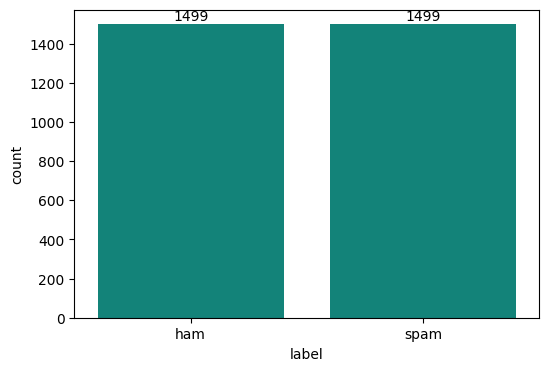

In [28]:
# Separate spam and ham
spam = data[data['label'] == 'spam']
ham = data[data['label'] == 'ham']


# Downsample Ham emails to match the number of Spam emails
ham_msg_balanced = ham.sample(n=len(spam), random_state=42)

# Combine and shuffle
data_balanced = pd.concat([ham_msg_balanced, spam]).reset_index(drop=True)

# Visualize the balanced dataset
plt.figure(figsize=(6,4))
sns.countplot(x=data_balanced['label'], color = '#009688')

# Add data labels
for p in plt.gca().patches:
    plt.text(
        p.get_x() + p.get_width() / 2, 
        p.get_height() + 5, 
        int(p.get_height()), 
        ha='center', 
        va='bottom'
    )
plt.show()

## **Step 4: Clean the Text**

In [29]:
data_balanced['text'] = data_balanced['text'].str.replace('Subject:', '')
data_balanced.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,conoco - big cowboy\r\ndarren :\r\ni ' m not ...,0
1,2982,ham,feb 01 prod : sale to teco gas processing\r\n...,0
2,2711,ham,"california energy crisis\r\ncalifornia  , s ...",0
3,3116,ham,re : nom / actual volume for april 23 rd\r\nw...,0
4,1314,ham,eastrans nomination changes effective 8 / 2 /...,0


In [30]:
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

data_balanced['text']= data_balanced['text'].apply(lambda x: remove_punctuations(x))
data_balanced.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,conoco big cowboy\r\ndarren \r\ni m not sur...,0
1,2982,ham,feb 01 prod sale to teco gas processing\r\ns...,0
2,2711,ham,california energy crisis\r\ncalifornia  s p...,0
3,3116,ham,re nom actual volume for april 23 rd\r\nwe ...,0
4,1314,ham,eastrans nomination changes effective 8 2 0...,0


In [31]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')

    imp_words = []

    # Storing the important words
    for word in str(text).split():
        word = word.lower()

        if word not in stop_words:
            imp_words.append(word)

    output = " ".join(imp_words)

    return output


data_balanced['text'] = data_balanced['text'].apply(lambda text: remove_stopwords(text))
data_balanced.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,conoco big cowboy darren sure help know else a...,0
1,2982,ham,feb 01 prod sale teco gas processing sale deal...,0
2,2711,ham,california energy crisis california  power cr...,0
3,3116,ham,nom actual volume april 23 rd agree eileen pon...,0
4,1314,ham,eastrans nomination changes effective 8 2 00 p...,0


#### Visualization Word Cloud
A word cloud is a text visualization tool that help's us to get insights into the most frequent words present in the corpus of the data.

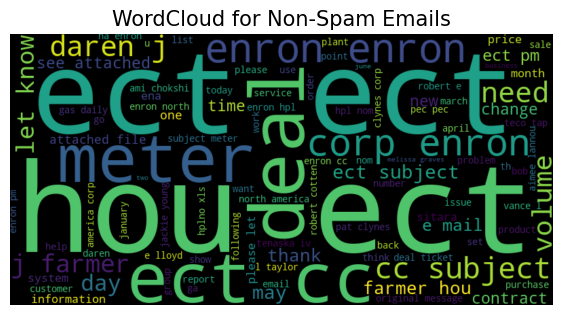

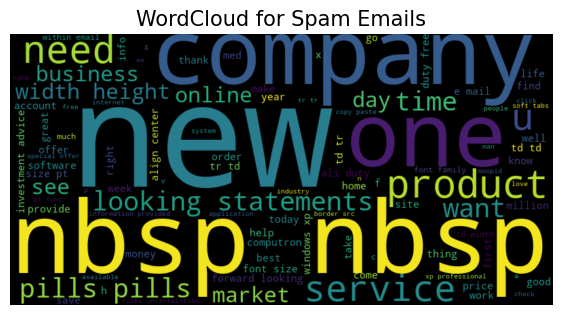

In [32]:
def plot_word_cloud(data, typ):
    email_corpus = " ".join(data['text'])
    wc = WordCloud(background_color='black', max_words=100, width=800, height=400).generate(email_corpus)
    plt.figure(figsize=(7, 7))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} Emails', fontsize=15)
    plt.axis('off')
    plt.show()

plot_word_cloud(data_balanced[data_balanced['label'] == 'ham'], typ='Non-Spam')
plot_word_cloud(data_balanced[data_balanced['label'] == 'spam'], typ='Spam')

## **Step 6: Tokenization and Padding**

Machine learning models work with numbers, so we need to convert the text data into numerical vectors using Tokenization and Padding.

- Tokenization: Converts each word into a unique integer.
- Padding: Ensures that all text sequences have the same length, making them compatible with the model.

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    data_balanced['text'], data_balanced['label'], test_size=0.2, random_state=42
)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

max_len = 100  # Maximum sequence length
train_sequences = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
test_sequences = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

y_train = (y_train == 'spam').astype(int)
y_test = (y_test == 'spam').astype(int)

## **Step 7: Define the Model**

I will build a deep learning model using a Sequential architecture. This model will include:

- Embedding Layer: Learns vector representations of words.
- LSTM Layer: Captures patterns in sequences.
- Fully Connected Layer: Extracts relevant features.
- Output Layer: Predicts whether an email is spam or not.

In [34]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=32, input_length=max_len),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer
])

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

model.build(input_shape=(None, max_len))
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 100, 32)        │     1,274,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,278,625 (4.88 MB)

 Trainable params: 1,278,625 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

## **Step 8: Train the Model**

In [35]:
# The model expects numeric labels (0 for ham, 1 for spam), not string labels.
# Use train_Y and test_Y for training and validation.

es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = ReduceLROnPlateau(patience=2, monitor='val_loss', factor=0.5, verbose=0)

history = model.fit(
    train_sequences, y_train,
    validation_data=(test_sequences, y_test),
    epochs=20,
    batch_size=32,
    callbacks=[lr, es]
)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.6093 - loss: 0.6591 - val_accuracy: 0.9467 - val_loss: 0.2900 - learning_rate: 0.0010
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.6093 - loss: 0.6591 - val_accuracy: 0.9467 - val_loss: 0.2900 - learning_rate: 0.0010
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9316 - loss: 0.2350 - val_accuracy: 0.9650 - val_loss: 0.1443 - learning_rate: 0.0010
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9316 - loss: 0.2350 - val_accuracy: 0.9650 - val_loss: 0.1443 - learning_rate: 0.0010
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.9520 - loss: 0.1991 - val_accuracy: 0.9233 - val_loss: 0.2674 - learning_rate: 0.0010
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.9520 - loss: 0.1991 - val_accuracy: 0.9233 - val_loss: 0.2674 - learning_rate: 0.0010
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9370 - loss: 0.2142 - val_acc

In [36]:
test_loss, test_accuracy = model.evaluate(test_sequences, y_test)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9650 - loss: 0.1443
Test Loss : 0.14429396390914917
Test Accuracy : 0.9649999737739563
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9650 - loss: 0.1443
Test Loss : 0.14429396390914917
Test Accuracy : 0.9649999737739563


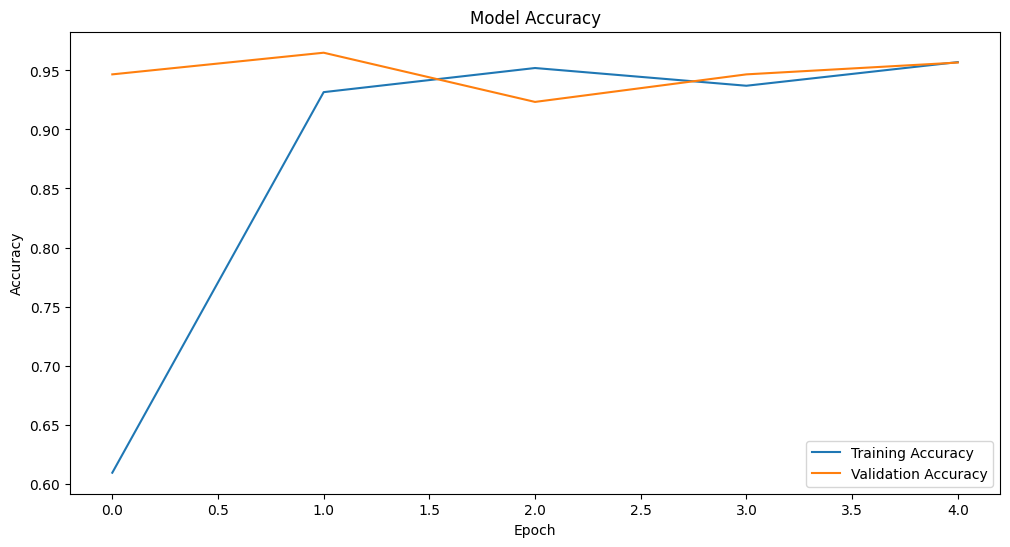

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()